<a href="https://colab.research.google.com/github/chandana1012/COVID-19/blob/Master/covid_19_detection_for_three_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
from fastai.vision import *

In [4]:
!git clone https://github.com/chandana1012/COVID-19.git

Cloning into 'COVID-19'...
remote: Enumerating objects: 511, done.
remote: Counting objects: 100% (511/511), done.
remote: Compressing objects: 100% (509/509), done.
remote: Total 1149 (delta 4), reused 507 (delta 2), pack-reused 638
Receiving objects: 100% (1149/1149), 397.86 MiB | 53.51 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Checking out files: 100% (1752/1752), done.


In [5]:
!ln -s "/content/COVID-19/X-RAY THREE CLASS DATASET"  /content/COVID-19/X-Ray_Image_DataSet

In [6]:
path = Path('/content/COVID-19/X-Ray_Image_DataSet/')
print(path)

/content/COVID-19/X-Ray_Image_DataSet


In [7]:
np.random.seed(41)
#data = ImageDataBunch.from_folder(path, train="Train", valid ="Valid", ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()
data = ImageDataBunch.from_folder(path, train="/content/COVID-19/X-Ray_Image_DataSet/Train",
                                  valid ="/content/COVID-19/X-Ray_Image_DataSet/Valid", 
                                ds_tfms=get_transforms(), valid_pct=0.2,size=(256,256), bs=32, num_workers=4).normalize()

In [8]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings', 'Pneumonia'], 3, 900, 225)

In [9]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 900
Number of examples in validation: 225


In [10]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

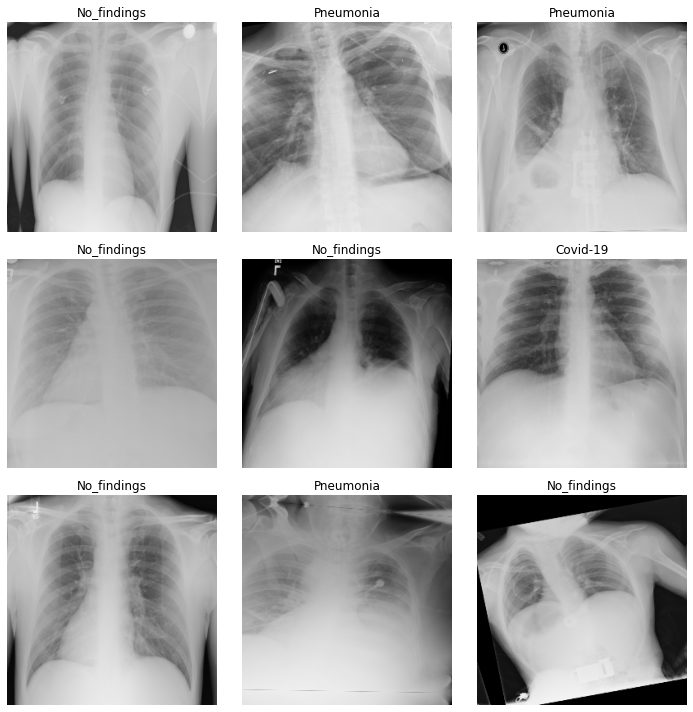

In [11]:
data.show_batch(rows=3, figsize=(10,10))

In [12]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

In [13]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [14]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [15]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 3),
    Flatten(),
    nn.Linear(507, 3)
)

In [16]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [17]:
learn.fit_one_cycle(100, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.855818,1.030475,0.453333,00:38
1,0.761202,0.595023,0.751111,00:38
2,0.697732,0.491006,0.826667,00:38
3,0.652247,0.559490,0.795556,00:38
4,0.619307,0.454536,0.844444,00:38
5,0.588260,0.414059,0.840000,00:38
6,0.573991,0.468078,0.831111,00:39
7,0.577382,0.423541,0.826667,00:39
8,0.573288,0.497441,0.795556,00:39
9,0.566362,0.389770,0.822222,00:39


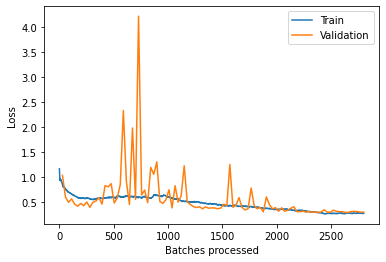

In [18]:
learn.recorder.plot_losses()

In [19]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 225


In [20]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) # Predicting without TTA

In [21]:
accuracy(probs,targets)

tensor(0.8844)

In [22]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings', 'Pneumonia'], 3, 900, 225)

In [23]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) # shows whole confusion matrix
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings', 'Pneumonia']
print(classification_report(y_true1, y_pred1, target_names=target_names))

225 199 0.8844444444444445
[[17  0  1]
 [ 0 94  8]
 [ 0 17 88]]
              precision    recall  f1-score   support

    Covid-19       1.00      0.94      0.97        18
 No_findings       0.85      0.92      0.88       102
   Pneumonia       0.91      0.84      0.87       105

    accuracy                           0.88       225
   macro avg       0.92      0.90      0.91       225
weighted avg       0.89      0.88      0.88       225



In [24]:
interp = ClassificationInterpretation.from_learner(learn)

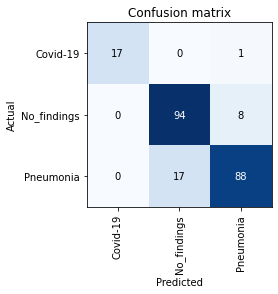

In [25]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);